In [2]:
def read_binary_with_structure(file_path, x_range=0, y_range=0):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        # print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        if  x_range==0 and y_range==0:
          x_min, x_max = [0,nx]
          y_min, y_max = [0,ny]
        else:    
          x_min, x_max = x_range
          y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        one = np.ones((nx, ny-1), dtype=np.float32)

        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        uc = uc[x_min:x_max+1,y_min:y_max+1]
        vc = vc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]
        one = one[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "nx":nx,
        "ny":ny,
        "x": xc,
        "y": yc,
        "u": uc,
        "v": vc,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
        "one": one,

    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡



#################################
#### P4P_.py ####
#################################

file_number : 502
impact_velocity: 20.0 [km/s]
solid_ball_radius: 3.01e-08 [m]
ts: 3.01e-12 [s]
target_density : 1.67e+01 [g/cc]
projectile_density : 1.00e+00 [g/cc]
ambience_initial_ionization_degree: 0.025740515
Target_initial_ionization_degree: 6.1756487
projectile_initial_ionization_degree: 1.2348504
xleft: -2.3 [nm],  xright: 3.3 [nm], y_max: 2.6 [nm]
extract_xleft: -19.8 [um], extract_xright: 200.0 [um], extract_y_max: 60.2 [um]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./B20/u0000.bin      time: 0.0 [s]
step: 1      file: ./B20/u0001.bin      time: 0.0 [s]
Step 1
Particle positions (x): min=-2.969999854940397e-07, max=1.9010002461072872e-06
Particle positions (y): min=9.999999717180685e-10, max=6.030215331520594e-07
Interpolated rho (rhos): min=9.99360441463193e-07, max=16.848368454421717

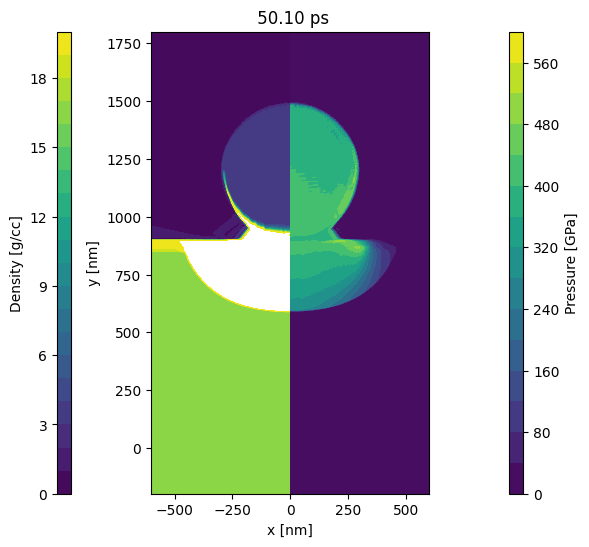

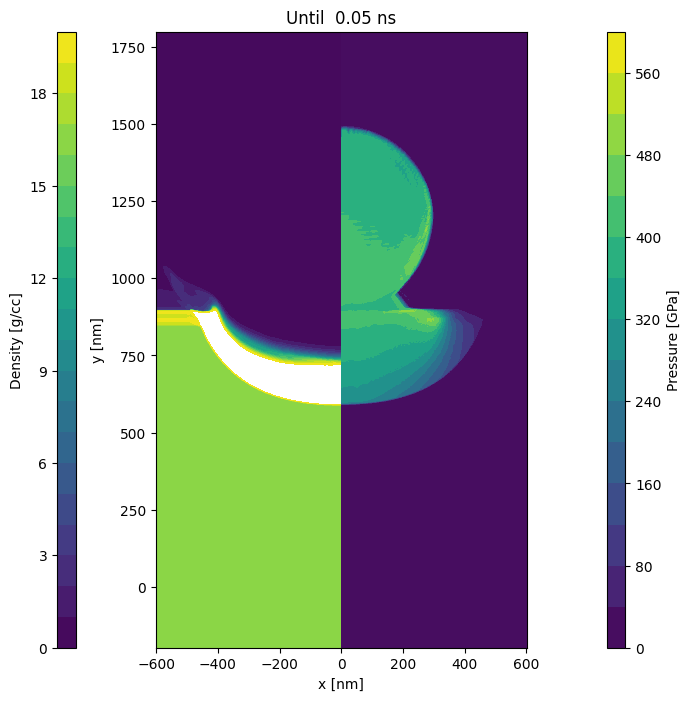

In [24]:
### mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

print("\n\n#################################")
print("#### P4P_.py ####")
print("#################################\n")


# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "B20"
os.makedirs('./Python/P4P_images/P4P_DenPre_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_IETmp_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_ZiMtl_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
# operation = "test_2"
operation = "actual"
if operation == "test_1":
  l = 1
  file = 0
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 3
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  files = sorted([os.path.join(d_name, f) for f in os.listdir(d_name) if f.endswith('.bin')])
  l = len(files)
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径の抽出
data = read_binary_with_structure(file_path)

nx = data['nx']
ny = data['ny']
x4 = data['x']
y4 = data['y']
u4 = data['u']
all_z = data['zi']
mtl = data['mtl']
rho = data['rho']
v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
projectile = np.where(u4[:,0] < 0)[0]
solid_ball_radius = (len(projectile)-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))

#密度と電離度の修正値の抽出
Target_all = np.where(mtl == 2)
projectile_all = np.where(mtl == 3)
ambience_all = np.where(mtl == 1)

target_density = rho[0,0]
projectile_density = rho[projectile[1],0]
print("target_density : {:.2e} [g/cc]".format(target_density))
print("projectile_density : {:.2e} [g/cc]".format(projectile_density))

ambience_init_ion_deg = np.max(all_z[ambience_all])
Target_init_ion_deg = np.max(all_z[Target_all])
projectile_init_ion_deg = np.max(all_z[projectile_all])
print('ambience_initial_ionization_degree:',ambience_init_ion_deg)
print('Target_initial_ionization_degree:',Target_init_ion_deg)
print('projectile_initial_ionization_degree:',projectile_init_ion_deg)

#計算領域の抽出
python_xleft = np.min(x4)*1e6
python_xright = np.max(x4)*1e6
python_y_out = np.max(y4)*1e6
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")


## 抽出したい範囲(cell number)
x_min = nxr1+1
x_max = nxr4
y_max = jj2
##描画領域(nm)
# x_nm_min = -200
# x_nm_max = 200
# y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
# 抽出したい範囲(nm)
x_nm_min = round(((x_min-nxr2)*grid_x)*1e9,1)
x_nm_max = round(((x_max-nxr2)*grid_x)*1e9,1)
y_nm_min = 0
y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")

max_p =[]
max_rho =[]
max_ti =[]
time = []


print("\n----- start loading -----")
for i in np.arange(0,l,1):

  if operation == "test_1":
    file_path = "./{}/u{:04d}.bin".format(d_name, file)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)

  print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")
    
  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  time.append(data["time"])


  if i == 0:
    x_particles = data["x"].flatten()
    y_particles = data["y"].flatten()
    x_particles_0 = data["x"].flatten()
    y_particles_0 = data["y"].flatten()
    max_p = np.zeros_like(data["P"].flatten())
    max_rho = np.zeros_like(data["rho"].flatten())

    # グリッド範囲
    x_grid_1 = np.linspace(data["x"].min(), data["x"].max(), data["P"].shape[0])
    y_grid_1 = np.linspace(data["y"].min(), data["y"].max(), data["P"].shape[1])


  if i >= 1:
    dt = time[i]-time[i-1]
    # 圧力フィールドの補間関数
    pressure_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["P"], bounds_error=False, fill_value=None)
    rho_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["rho"], bounds_error=False, fill_value=None)
    
    # 速度フィールドの補間関数
    u_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["u"], bounds_error=False, fill_value=0)
    v_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["v"], bounds_error=False, fill_value=0)
    
    # 現在位置での圧力を取得し、最大圧力を更新
    current_positions = np.array([x_particles, y_particles]).T
    pressures = pressure_interp(current_positions)
    rhos = rho_interp(current_positions)
    max_p = np.maximum(max_p, pressures)
    max_rho = np.maximum(max_rho, rhos)

    # 速度に基づいて粒子位置を更新
    u = u_interp(current_positions)
    v = v_interp(current_positions)
    x_particles += u * dt
    y_particles += v * dt

    print(f"Step {i}")
    print(f"Particle positions (x): min={x_particles.min()}, max={x_particles.max()}")
    print(f"Particle positions (y): min={y_particles.min()}, max={y_particles.max()}")
    print(f"Interpolated rho (rhos): min={rhos.min()}, max={rhos.max()}")

    print(f"Interpolation range (x_grid_1): {x_grid_1.min()} - {x_grid_1.max()}")
    print(f"Interpolation range (y_grid_1): {y_grid_1.min()} - {y_grid_1.max()}")


# print(data)
print('-------------------------')


fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(111,aspect='equal')
# Set up a pylab figure
# set axis labels
ax1.set_xlabel('x [nm]')
ax1.set_ylabel('y [nm]')
# set axis limits
ax1.set_ylim([x_nm_min*10,x_nm_max*9])
ax1.set_xlim([-y_nm_max*10,y_nm_max*10])
# ax1.set_xlim([python_xleft,python_xright])
# ax1.set_ylim([-python_y_out,python_y_out])

# Plot field
p1=ax1.tricontourf(data["y"].flatten()*1e9,data["x"].flatten()*1e9,max_p.flatten()*1e-9,levels=np.linspace(0,600,16))
p2=ax1.tricontourf(-data["y"].flatten()*1e9,data["x"].flatten()*1e9,max_rho.flatten(),levels=np.linspace(0,20,21))

# add color bar
# create colorbars to either side of the plot
divider = make_axes_locatable(ax1)
cx1=divider.append_axes("right", size="5%", pad=0.8)
cx2=divider.append_axes("left", size="5%", pad=0.8)
cb3=fig.colorbar(p1,cax=cx1)
cb3.set_label('Pressure [GPa]')
cb4=fig.colorbar(p2,cax=cx2)
cb4.set_label('Density [g/cc]')

# set labels on left for left side colorbar
cx2.yaxis.tick_left()
cx2.yaxis.set_label_position('left')

# set title
ax1.set_title('{: 5.2f} ps'.format(data["time"]*1e12))

if operation == "actual":
  fig.savefig('./Python/P4P_images/P4P_DenPre_{}/P4P_DenPre_{:05d}.png'.format(d_name,i))
  # clear axis for next step

fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(111,aspect='equal')
    # Set up a pylab figure
    # set axis labels
ax1.set_xlabel('x [nm]')
ax1.set_ylabel('y [nm]')
    # set axis limits
ax1.set_ylim([x_nm_min*10,x_nm_max*9])
ax1.set_xlim([-y_nm_max*10,y_nm_max*10])
    # ax1.set_xlim([python_xleft,python_xright])
    # ax1.set_ylim([-python_y_out,python_y_out])


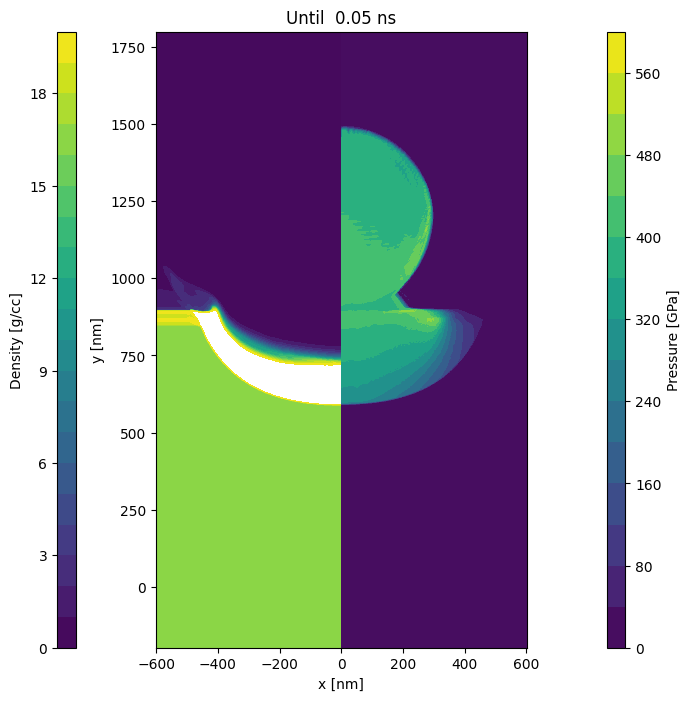

In [28]:
fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(111,aspect='equal')
    # Set up a pylab figure
    # set axis labels
ax1.set_xlabel('x [nm]')
ax1.set_ylabel('y [nm]')
    # set axis limits
ax1.set_ylim([x_nm_min*10,x_nm_max*9])
ax1.set_xlim([-y_nm_max*10,y_nm_max*10])
    # ax1.set_xlim([python_xleft,python_xright])
    # ax1.set_ylim([-python_y_out,python_y_out])
    
    # Plot field
p1=ax1.tricontourf(y_particles_0*1e9,x_particles_0*1e9,max_p*1e-9,levels=np.linspace(0,600,16))
p2=ax1.tricontourf(-y_particles_0*1e9,x_particles_0*1e9,data["rho"].flatten(),levels=np.linspace(0,20,21))
    
    # add color bar
    # create colorbars to either side of the plot
divider = make_axes_locatable(ax1)
cx1=divider.append_axes("right", size="5%", pad=0.8)
cx2=divider.append_axes("left", size="5%", pad=0.8)
cb3=fig.colorbar(p1,cax=cx1)
cb3.set_label('Pressure [GPa]')
cb4=fig.colorbar(p2,cax=cx2)
cb4.set_label('Density [g/cc]')
    
    # set labels on left for left side colorbar
cx2.yaxis.tick_left()
cx2.yaxis.set_label_position('left')
   
    # set title
ax1.set_title('Until {: 5.2f} ns'.format(data["time"]*1e9))
    
if operation == "actual":
      fig.savefig('./Python/P4P_trace/trace_{}.png'.format(d_name))
      # clear axis for next step

In [26]:
data["x"].shape

(1250, 450)

In [27]:
data["x"]#m

array([[-3.1683703e-07, -3.1683703e-07, -3.1683703e-07, ...,
        -3.1683703e-07, -3.1683703e-07, -3.1683703e-07],
       [-3.1058465e-07, -3.1058465e-07, -3.1058465e-07, ...,
        -3.1058465e-07, -3.1058465e-07, -3.1058465e-07],
       [-3.0447910e-07, -3.0447910e-07, -3.0447910e-07, ...,
        -3.0447910e-07, -3.0447910e-07, -3.0447910e-07],
       ...,
       [ 2.2256822e-07,  2.2256822e-07,  2.2256822e-07, ...,
         2.2256822e-07,  2.2256822e-07,  2.2256822e-07],
       [ 2.3298186e-07,  2.3298186e-07,  2.3298186e-07, ...,
         2.3298186e-07,  2.3298186e-07,  2.3298186e-07],
       [ 2.4419077e-07,  2.4419077e-07,  2.4419077e-07, ...,
         2.4419077e-07,  2.4419077e-07,  2.4419077e-07]], dtype=float32)

In [28]:
data["x"].flatten()

array([-3.1683703e-07, -3.1683703e-07, -3.1683703e-07, ...,
        2.4419077e-07,  2.4419077e-07,  2.4419077e-07], dtype=float32)

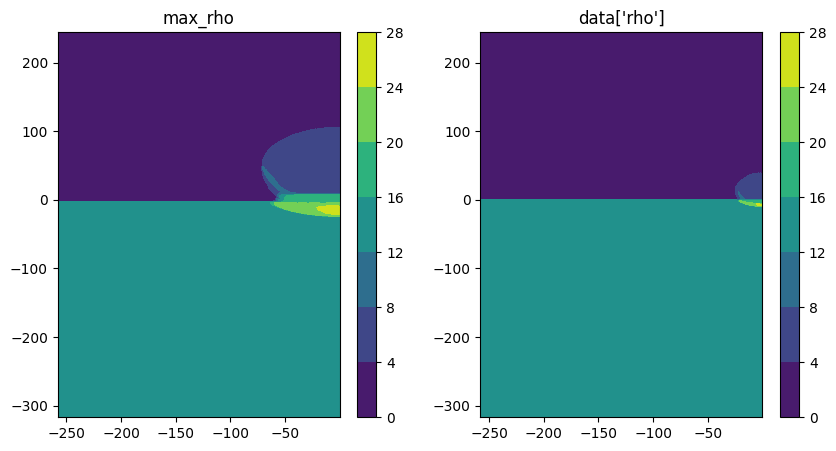

In [31]:
plt.figure(figsize=(10, 5))

# max_rho のプロット
plt.subplot(1, 2, 1)
plt.tricontourf(-data["y"].flatten() * 1e9, data["x"].flatten() * 1e9, max_rho.flatten(), cmap='viridis')
plt.title("max_rho")
plt.colorbar()

# data["rho"] のプロット
plt.subplot(1, 2, 2)
plt.tricontourf(-data["y"].flatten() * 1e9, data["x"].flatten() * 1e9, data["rho"].flatten(), cmap='viridis')
plt.title("data['rho']")
plt.colorbar()

plt.show()
